# Отток клиентов. 

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.\
Необходимо построить модель с предельно большим значением F1-меры. Для успешного выполнениния задачи, нужно довести метрику до 0.59. Так же необходимо проверить F1-меру на тестовой выборке.\
Дополнительно необходимо измерять AUC-ROC и сравнивать её значение с F1-мерой.


**Описание данных:** \
Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»).

**Признаки:** 

**RowNumber** — индекс строки в данных.\
**CustomerId** — уникальный идентификатор клиента.\
**Surname** — фамилия.\
**CreditScore** — кредитный рейтинг.\
**Geography** — страна проживания.\
**Gender** — пол.\
**Age** — возраст.\
**Tenure** — сколько лет человек является клиентом банка.\
**Balance** — баланс на счёте.\
**NumOfProducts** — количество продуктов банка, используемых клиентом.\
**HasCrCard** — наличие кредитной карты.\
**IsActiveMember** — активность клиента.\
**EstimatedSalary** — предполагаемая зарплата.

**Целевой признак:** 

**Exited** — факт ухода клиента.


**Цель исследования:** Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Построим модель с наибольшим значением F1-меры. Для успешного выполнениния задачи, доведем метрику до 0.59. Проверим F1-меру на тестовой выборке.\
Дополнительно будем измерять AUC-ROC и сравнивать её значение с F1-мерой.

**Ход исследоввания:**
Загрузим и подготовим данные.
Исследуем баланс классов, обучим модель без учёта дисбаланса. Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую. Опишем выводы.
Проведем финальное тестирование.

**Исследование пройдет в пять этапов:**

1) Изучение общей информации о данных и подготовим их.
2) Исследование баланса классов. Обучение модели без учёта дисбаланса.
   Улучшение качества модели, учитывая дисбаланс классов.
3) Обучение разных моделей и поиск лучшей.
4) Проведение финальнонго тестирования.
5) Общий вывод.

# 1. Откроем файл с данными и изучим общую информацию. 

In [1]:
# импортируем необходимые библиотеки
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
import numpy as np
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report, 
    precision_recall_curve, roc_curve, roc_auc_score
)

In [2]:
# прочитаем данные из csv-файла в датафрейм и сохраним в переменную 
try:
    data = pd.read_csv('/Users/Slava/Desktop/Яндекс Практикум учебные материалы/Проекты/Проект7./Churn.csv', sep = ',')
except: 
     data = pd.read_csv('/datasets/Churn.csv', sep = ',') 

In [3]:
# ознакомимся с общей информацией о данных
data.info()

In [4]:
# выведем первые 10 строк набора данных, ознакомимся с признаками и объектами
data.head(10)

Взглянув на данные мы сразу видим, что первые три стобца данных: 'RowNumber', 'CustomerId', 'Surname' не содержат в себе полезной информации для исследования. Отбросим их.

In [5]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [6]:
# ознакомимся с описательной статистикой набора данных
data.describe()

In [7]:
# проверим пропуски в данных
data.isna().sum()

Пропуски присутствуют только столбце 'Tenure'. Количество их значительно, ~ 10% от количества всех данных, поэтому их исключение может негативно сказаться на исследованни. 
Рациональнее будет заменить пропуски медианным значением.

In [8]:
data.Tenure = data.Tenure.fillna(data.Tenure.median())
data.isna().sum()

Так же изменим тип данных столбца, так как год является целочисленным значением, заодно приведем к типу 'int' столбцы 'Balance' и 'EstimatedSalary' так как значения после целой части

In [9]:
for columns in ['Tenure','Balance','EstimatedSalary']:
    data[columns] = data[columns].astype(int)
data.info()

**Перед нами задача бинарной классификации:** уйдёт клиент из банка в ближайшее время или нет. Значение Exited = 1 или 0 соответственно.

Так как моделям для корректной работы в качестве входных данных мы должны передавать только численные признаки, необходимо подготовить датасет, а именно категориальные признаки 'Geography' и 'Gender' преобразовав их в численные универсальной техникой прямого кодирования (One-Hot Encoding). Чтобы не попасть в дамми-ловушку (dummy trap, ловушка фиктивных признаков), в функции pd.get_dummies() укажем аргумент drop_first=True, чтобы отбросить один столбец, который легко восстанавливается по остальным.

In [10]:
# применим технику прямого кодирования
data = pd.get_dummies(data, drop_first=True)
# проверим результат
data.head()

Отлично, категориальных данных не осталось.

Оценим баланс выборки т.е. соотношение ушедших/не ушедших клиентов от общего количества.

In [11]:
data['Exited'].value_counts()/len(data)

Данные не сбалансированны. В исходных данных количество ушедших из банка клиентов составляет ~ 20% от общего числа. Учтем это при разделении выборки используя метод стратификации.

Создадим переменные целевого и остальных признаков для обучения моделей.

In [12]:
features = data.drop(['Exited'], axis=1)
target = data['Exited'] 
# проверим 
features.shape, target.shape

Разделим выборку на обучающую, валидационную и тестовую в отношении 3:1:1.

In [13]:
# сначала разобъем выборку на обучающую и 'осаточную' в пропорции 60/40,
# применим 'stratify' для равномерного разделения значений в признаке.
features_train, features_remaining, target_train, target_remaining = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)
# разобъем 'остаточную' выборку на тестовую и валидационную в пропорциях 50/50, 
# так же применив 'stratify' для равномерного разделения значений в 'остаточной' выборке.
features_valid, features_test, target_valid, target_test = train_test_split(
    features_remaining, target_remaining, test_size=0.5, random_state=12345, stratify=target_remaining)

print(f'Размеры выборок:')
print(f'Обучающая: {len(features_train)}')
print(f'Валидационная: {len(features_valid)}')
print(f'Тестовая: {len(features_test)}')

Отлично, разделение произвели корректно.

In [14]:
# проверим сохранение пропорций равномерного распределения значений в выборках
for tr in [target_train, target_valid, target_test]:
    print(tr.value_counts()/len(tr))

Исходные данные разделены на обучающую, валидационную и тестовую в отношении 3:1:1 с соблюдением пропорции соотношения целевых признаков.

Данные готовы к исследованию.

Взглянув на исходную таблицу, можно заметить, что значения разных объектов имеют существенный разброс, модель будет считать высокие значения более значимыми, это приведет к некорректной работе модели. Воспользуемся масштабированием, а именно методом стандартизации.

In [15]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train

Данные готовы для обучения и исследования моделей. Пропуски обработанны, категориальные признаки преобразованы к численным методом (OHE), а численные признаки стандартизированы. Выделен целевой признак, исходная выборка разделена на обучающую, валидационную и тестовую.

# 2. Исследование баланса классов. 

## 2.1 Обучение модели без учёта дисбаланса.

Обучим модели без учета дисбаланса, и посмотрим на ключевые метрики - Recall, Precision и F1-score.
Перед этим подберем оптимальные гиперпараметры для моделей на основании метрики F1-score.

### 2.1.1 Обучение модели 'Дерево решений'.

In [16]:
%%time
# подберем лучшие гиперпараметры
best_model = None
best_f1 = 0
for depth in range(1, 12):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Лучшая глубина дерева =', best_depth) 
print('Качество метрики F1 - ', f1_tree)

In [17]:
%%time
# обучаем модель с оптимальными значениями гиперпараметров
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=7)
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)
# выведем результаты
print("Recall score:", recall_score(target_valid, predictions_valid_tree))
print("Precision score:", precision_score(target_valid, predictions_valid_tree))
print("F1 score:", f1_score(target_valid, predictions_valid_tree))

### 2.1.2 Обучение модели 'Случайный лес'.

In [18]:
%%time
# подберем лучшие гиперпараметры
best_model = None
for est in range(10, 100, 10):
    for depth in range(1, 12):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Лучшее количество деревьев =', best_est)
print('Лучшая глубина дерева =', best_depth)
print('Качество метрики F1 - ', f1_forest)

In [19]:
%%time
# обучаем модель с оптимальными значениями гиперпараметров
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=90, 
                                      max_depth=11)
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)
# выведем результаты
print("Recall score:", recall_score(target_valid, predictions_valid_forest))
print("Precision score:", precision_score(target_valid, predictions_valid_forest))
print("F1 score:", f1_score(target_valid, predictions_valid_forest))

### 2.1.3 Обучение модели 'Логистическая регрессия'.

In [20]:
# построим модель
model_logr = LogisticRegression(random_state=12345,
                               solver='liblinear')
model_logr.fit(features_train, target_train)
predictions_valid_logr = model_logr.predict(features_valid)

print("Recall score:", recall_score(target_valid, predictions_valid_logr))
print("Precision score:", precision_score(target_valid, predictions_valid_logr))
print("F1 score:", f1_score(target_valid, predictions_valid_logr))

Подводя итог работы моделей без учета дисбаланса классов посмотрим на значения F1 метрики каждой модели:

1) **'Дерево решений'**(параметры: max_depth=7) | **F1 score = 0.54**
2) **'Случайный лес'**(параметры: n_estimators=90, max_depth=11) | **F1 score = 0.60**
3) **'Логистическая регрессия'**(параметры: solver='liblinear') | **F1 score = 0.30**

Таким образом, наилучшее значение метрики F1-score демонстрирует модель Случайный лес. Фактически цель достигнута.

## 2.2 Обучение модели с учётом дисбаланса.

### 2.2.1 Обучение модели 'Дерево решений'.

In [21]:
%%time
# подберем лучшие гиперпараметры
best_model = None
best_f1 = 0
for depth in range(1, 12):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth,
                                        class_weight='balanced'
                                       )
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Лучшая глубина дерева =', best_depth) 
print('Качество метрики F1 - ', f1_tree)

In [22]:
%%time
# обучаем модель с оптимальными значениями гиперпараметров
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=6)
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)
# выведем результаты
print("Recall score:", recall_score(target_valid, predictions_valid_tree))
print("Precision score:", precision_score(target_valid, predictions_valid_tree))
print("F1 score:", f1_score(target_valid, predictions_valid_tree))
# посчитаем roc_auc score
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

### 2.2.2 Обучение модели 'Случайный лес'.

In [23]:
%%time
# подберем лучшие гиперпараметры
best_model = None
for est in range(10, 100, 10):
    for depth in range(1, 12):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth,
                                              class_weight='balanced'
                                             )
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Лучшее количество деревьев =', best_est)
print('Лучшая глубина дерева =', best_depth)
print('Качество метрики F1 - ', f1_forest)

In [24]:
%%time
# обучаем модель с оптимальными значениями гиперпараметров
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=90, 
                                      max_depth=11,
                                      class_weight='balanced'
                                     )
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)
# выведем результаты
print("Recall score:", recall_score(target_valid, predictions_valid_forest))
print("Precision score:", precision_score(target_valid, predictions_valid_forest))
print("F1 score:", f1_score(target_valid, predictions_valid_forest))
# посчитаем roc_auc score
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

### 2.2.3 Обучение модели 'Логистическая регрессия'.

In [25]:
# построим модель
model_logr = LogisticRegression(random_state=12345,
                               solver='liblinear',
                               class_weight='balanced'
                               )
model_logr.fit(features_train, target_train)
predictions_valid_logr = model_logr.predict(features_valid)

print("Recall score:", recall_score(target_valid, predictions_valid_logr))
print("Precision score:", precision_score(target_valid, predictions_valid_logr))
print("F1 score:", f1_score(target_valid, predictions_valid_logr))
# посчитаем roc_auc score
probabilities_valid = model_logr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

# 3. Обучение моделей и поиск лучшей.

## 3.1 Уменьшение выборки.

In [26]:
# уменьшим выборку в 4 раза, так как положительный класс больше отрицательного примерно в 4 раза (доля: 0.7963 / 0.2037)
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # fractioning samples
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] +
                                   [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

### 3.1.1 Обучение модели 'Дерево решений'.

In [27]:
%%time
# подберем лучшие гиперпараметры
best_model = None
best_f1 = 0
for depth in range(1, 12):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_downsampled, target_downsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Лучшая глубина дерева =', best_depth) 
print('Качество метрики F1 - ', f1_tree)

In [28]:
%%time
# обучаем модель с оптимальными значениями гиперпараметров
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=6)
model_tree.fit(features_downsampled, target_downsampled)
predictions_valid_tree = model_tree.predict(features_valid)
# выведем результаты
print("Recall score:", recall_score(target_valid, predictions_valid_tree))
print("Precision score:", precision_score(target_valid, predictions_valid_tree))
print("F1 score:", f1_score(target_valid, predictions_valid_tree))
# посчитаем roc_auc score
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

### 3.1.2 Обучение модели 'Случайный лес'.

In [29]:
%%time
# подберем лучшие гиперпараметры
best_model = None
for est in range(10, 100, 10):
    for depth in range(1, 12):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_downsampled, target_downsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Лучшее количество деревьев =', best_est)
print('Лучшая глубина дерева =', best_depth)
print('Качество метрики F1 - ', f1_forest)

In [30]:
%%time
# обучаем модель с оптимальными значениями гиперпараметров
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=90, 
                                      max_depth=11)
model_forest.fit(features_downsampled, target_downsampled)
predictions_valid_forest = model_forest.predict(features_valid)
# выведем результаты
print("Recall score:", recall_score(target_valid, predictions_valid_forest))
print("Precision score:", precision_score(target_valid, predictions_valid_forest))
print("F1 score:", f1_score(target_valid, predictions_valid_forest))
# посчитаем roc_auc score
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

### 3.1.3 Обучение модели 'Логистическая регрессия'.

In [31]:
# построим модель
model_logr = LogisticRegression(random_state=12345,
                               solver='liblinear')
model_logr.fit(features_downsampled, target_downsampled)
predictions_valid_logr = model_logr.predict(features_valid)

print("Recall score:", recall_score(target_valid, predictions_valid_logr))
print("Precision score:", precision_score(target_valid, predictions_valid_logr))
print("F1 score:", f1_score(target_valid, predictions_valid_logr))
# посчитаем roc_auc score
probabilities_valid = model_logr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

## 3.2 Увеличение выборки.

In [32]:
# увеличим выборку в 4 раза, так как отрицательный класс больше положительного в 4 раза (доля: 0.7963 / 0.2037)
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # сцепляем выборки
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешиваем значения, чтобы они не шли друг за другом 
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

### 3.2.1 Обучение модели 'Дерево решений'.

In [33]:
%%time
# подберем лучшие гиперпараметры
best_model = None
best_f1 = 0
for depth in range(1, 12):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Лучшая глубина дерева =', best_depth) 
print('Качество метрики F1 - ', f1_tree)

In [34]:
%%time
# обучаем модель с оптимальными значениями гиперпараметров
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=6)
model_tree.fit(features_upsampled, target_upsampled)
predictions_valid_tree = model_tree.predict(features_valid)
# выведем результаты
print("Recall score:", recall_score(target_valid, predictions_valid_tree))
print("Precision score:", precision_score(target_valid, predictions_valid_tree))
print("F1 score:", f1_score(target_valid, predictions_valid_tree))
# посчитаем roc_auc score
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

### 3.2.2 Обучение модели 'Случайный лес'.

In [35]:
%%time
# подберем лучшие гиперпараметры
best_model = None
for est in range(10, 100, 10):
    for depth in range(1, 12):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_upsampled, target_upsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Лучшее количество деревьев =', best_est)
print('Лучшая глубина дерева =', best_depth)
print('Качество метрики F1 - ', f1_forest)

In [36]:
%%time
# обучаем модель с оптимальными значениями гиперпараметров
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=90, 
                                      max_depth=11)
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid_forest = model_forest.predict(features_valid)
# выведем результаты
print("Recall score:", recall_score(target_valid, predictions_valid_forest))
print("Precision score:", precision_score(target_valid, predictions_valid_forest))
print("F1 score:", f1_score(target_valid, predictions_valid_forest))
# посчитаем roc_auc score
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

### 3.2.3 Обучение модели 'Логистическая регрессия'.

In [37]:
# построим модель
model_logr = LogisticRegression(random_state=12345,
                               solver='liblinear')
model_logr.fit(features_upsampled, target_upsampled)
predictions_valid_logr = model_logr.predict(features_valid)

print("Recall score:", recall_score(target_valid, predictions_valid_logr))
print("Precision score:", precision_score(target_valid, predictions_valid_logr))
print("F1 score:", f1_score(target_valid, predictions_valid_logr))
# посчитаем roc_auc score
probabilities_valid = model_logr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

In [38]:
# для удобства соберем все полученные значения метрики F1-score в один датафрейм

model_name = ['TreeClassifier', 'RandomForest', 'LogReg']
initial_values = [0.59, 0.60, 0.30]
weighting_values = [0.57, 0.63, 0.52]
down_values = [0.59, 0.61, 0.52]
up_values = [0.57, 0.64, 0.52]

df_metrics = pd.DataFrame({'Model Name': model_name,
                           'Initial': initial_values,
                           'Weighing': weighting_values,
                           'Downsampling': down_values,
                           'Upsampling': up_values })

df_metrics

**Вывод:**

Уменьшение и увеличение выборки позволяют достичь примерно одинаковое значение F1-score.
Наибольшее значение метрики F1-score получено на модели Случайный лес при помощи увеличения выборки, соответственно для тестирования будем использовать эту модель.
Значение метрики AUC-ROC всегда стабильно выше F1-score и колеблется в районе 80%.

# 4. Проведение финальнонго тестирования.

Наиболее высокое значение F1, которого удалось добиться на валидационной выборке, равно 0.646 и получено с помощью модели RandomForestClassifier, то есть при учете дисбаланса классов с помощью увеличения выборки.

Можно сделать вывод, что модель, обученная с учетом увеличения выборки, справляется с прогнозами лучше, так как получает более сбалансированную выборку и уже не склонна всегда отдавать предпочтение более частому классу.

Обучим лучшую модель на тренировочной выборке и проведем финальное тестирование на тестовой.

In [39]:
model_forest = RandomForestClassifier(random_state=12345, max_depth=12, n_estimators=90)
model_forest.fit(features_upsampled, target_upsampled)
predictions_test = model_forest.predict(features_test)
test_probabilities = model_forest.predict_proba(features_test)
test_probabilities_one = test_probabilities[:, 1]

print("Recall forest test:", recall_score(target_test, predictions_test))
print("Precision forest test:", precision_score(target_test, predictions_test))
print("F1 tree test:", f1_score(target_test, predictions_test))

test_probabilities = model_forest.predict_proba(features_test)
test_probabilities_one = test_probabilities[:, 1]
print("ROC-AUC forest test:", roc_auc_score(target_test, test_probabilities_one))

На тестовой выборке результат Случайного леса получили ниже, что логично учитывая ее размерность по отношению к общей.

Построим ROC-curve график.

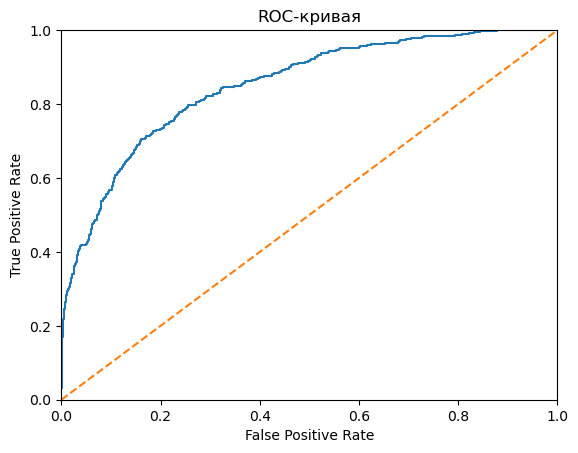

In [41]:
fpr, tpr, thresholds = roc_curve(target_test, test_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr, linestyle='solid')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

График показывает хорошее качество работы выбранной модели.

# 5. Общий вывод.

Для проведения данного исследования была произведена предварительная подготовка данных.

Произведено заполнение пропусков в данных столбца 'Tenure' на медианное значение.\
Удалены 3 категориальных столбца CustomerId, Surname и RowNumber, так как они никак позитивно не влияют на качество обучения.\
Категориальные признаки (Gender, Geography) были преобразованы в бинарные при помощи техники OHE.\
К признакам (CreditScore, Balance и EstimatedSalary) было применено масштабирование для уравнения их значимости.
Проверка датасета на наличие дисбаланса показала, что в целевом признаке наблюдается достаточно сильный дисбаланс классов - только 20% отражают факт ухода клиента.

В рамках борьбы с дисбалансом классов было рассмотрено 3 метода:

Взвешивание классов\
Увеличение выборки (upsampling)\
Уменьшение выборки (downsampling)\
Значения метрики F1-score, полученные на первом этапе исследования:

**'Дерево решений'(параметры: max_depth=7) | F1 score = 0.54** \
**'Случайный лес'(параметры: n_estimators=90, max_depth=11) | F1 score = 0.60** \
**'Логистическая регрессия'(параметры: solver='liblinear') | F1 score = 0.30**

В результате борьбы с дисбанансом классов были получены следующие выводы:

**'Дерево решений'(параметры: max_depth=6) | F1 score = 0.57** \
**'Случайный лес'(параметры: n_estimators=90, max_depth=11) | F1 score = 0.63** \
**'Логистическая регрессия'(параметры: solver='liblinear') | F1 score = 0.52**

Уменьшение и увеличение выборки позволяют достичь примерно одинаковое значение F1-score, однако наилучшие значения метрик получились при увеличении выборки (upsampled):

**'Дерево решений'(параметры: max_depth=6) | F1 score = 0.57** \
**'Случайный лес'(параметры: n_estimators=90, max_depth=11) | F1 score = 0.64** \
**'Логистическая регрессия'(параметры: solver='liblinear') | F1 score = 0.52**

Наибольшее значение метрики F1-score получено на модели Случайный лес при помощи увеличения выборки. Поэтому для финального тестирования была использована именно она.
Значение метрики AUC-ROC всегда стабильно выше F1-score и колеблется в районе 80%.
Далее, наилучшая модель была протестирована на тестовой выборке.

**F1-score = 0.594 (выше необходимого значения)** \
**AUC-ROC = 0.849 (достаточно близко к единице)**

При этом полнота лучше точности (0.60 против 0.58), то есть модель довольно неплохо находит объекты положительного класса, но при этом ошибается, называя отрицательные объекты положительными. Устраивают ли такие значения точности и полноты зависит от требований заказчика.